In [ ]:
# SEP769 - July 27, 2021
# Amir Kamaleddine, Ernani Fantinatti, Mohammed Ibraheem
# LSTM model for classifying normal and imbalanced motors as part of the MAFAULDA motor fault dataset
# If training, we suggest you use GPU acceleration in Colab
# https://github.com/efantinatti/MAFAULDA_SEP769

In [ ]:
# Load in tensorboard extension to view results interactively
%load_ext tensorboard


In [ ]:
# Load relevant libraries
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, SimpleRNN, LSTM
import matplotlib.pyplot as plt
import numpy as np
import glob
import datetime


In [ ]:
# For Google Colab only
# Pulling processed data from public folder
# Credit to this stack overflow forum: https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import gdown

url = 'https://drive.google.com/uc?id=1otE_HKfM24r9Hp1-e5xodSkgve1o3DO5' 
output = 'jul27data.zip'
gdown.download(url, output, quiet=False)

!unzip /content/jul27data.zip
!rm -rf sample_data


In [6]:
# Cloning github repo
!git clone https://github.com/efantinatti/MAFAULDA_SEP769.git


fatal: destination path 'MAFAULDA_SEP769' already exists and is not an empty directory.


In [7]:
# Decide whether to load model from a .h5 file or train a new one
saved_model = 0


In [8]:
#Delete tensorboard logs from previous runs
#If using Collab or Unix system use !rm, otherwise
#if using windows skip this
!rm -rf ./logs/


In [9]:
# Loads train/test data from .txt files to np arrays 
# Ensure you choose the correct file directory

dir = '/content/jul27data/'
train_reload = np.loadtxt(dir + 'train_data.txt')
test_reload = np.loadtxt(dir + 'test_data.txt')

print("Loaded data files...")


Loaded data files...


In [10]:
# Shaping the training/testing data
# Shapes the data into an nx50x8 array
# Each sequence is 50 timesteps (1 ms of data collection)

train_data = np.reshape(train_reload,(-1,50, 8))
test_data = np.reshape(test_reload,(-1,50, 8))


In [11]:
# Loads labels corresponding to training/test data
train_label = np.loadtxt(dir + 'train_label.txt').astype(int)
test_label = np.loadtxt(dir + 'test_label.txt').astype(int)

# Organized data is labeled per 500 timesteps
# To align the number of labels with number of sequences, need to correct number of labels
# These lines correct the number of labels
A = sum(train_label == 1)
B = sum(test_label == 1)
train_label = np.zeros((train_label.shape-A)*10)
train_label = np.append(train_label,np.ones(A*10))
test_label = np.zeros((test_label.shape-B)*10)
test_label = np.append(test_label,np.ones(B*10))


In [12]:
# Build the model
# Sequential model
model = Sequential()

# LSTM layers
model.add(LSTM(24, input_shape = (50,8), activation = 'tanh', recurrent_activation='sigmoid', return_sequences=True))
model.add(LSTM(12, activation = 'tanh', recurrent_activation='sigmoid', return_sequences=True))
model.add(LSTM(4, activation = 'tanh', recurrent_activation='sigmoid'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile model
# Binary crossentropy for a binary classifier
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 24)            3168      
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 12)            1776      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 272       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 5,221
Trainable params: 5,221
Non-trainable params: 0
_________________________________________________________________


In [13]:
ld = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callTensorboard = tf.keras.callbacks.TensorBoard(log_dir=ld, histogram_freq=1)


In [14]:
if saved_model == 0:
    # Train model
    # Note that validation data is NOT used to train model at all
    history = model.fit(train_data, train_label, validation_data=(test_data, test_label), callbacks=[callTensorboard], epochs=20, batch_size=50)
    model.save('/content/MAFAULDA_SEP769/Models/LSTM.h5')    
else:
    # Load model from .h5 file
    model = load_model('/content/MAFAULDA_SEP769/Models/LSTM.h5')


Epoch 1/20
998/998 [==============================] - 35s 12ms/step - loss: 0.4379 - accuracy: 0.8154 - val_loss: 0.2302 - val_accuracy: 0.9116
Epoch 2/20
998/998 [==============================] - 10s 10ms/step - loss: 0.2078 - accuracy: 0.9206 - val_loss: 0.1986 - val_accuracy: 0.9294
Epoch 3/20
998/998 [==============================] - 9s 10ms/step - loss: 0.1642 - accuracy: 0.9387 - val_loss: 0.1704 - val_accuracy: 0.9385
Epoch 4/20
998/998 [==============================] - 10s 10ms/step - loss: 0.1387 - accuracy: 0.9507 - val_loss: 0.1462 - val_accuracy: 0.9473
Epoch 5/20
998/998 [==============================] - 10s 10ms/step - loss: 0.1163 - accuracy: 0.9582 - val_loss: 0.1308 - val_accuracy: 0.9549
Epoch 6/20
998/998 [==============================] - 11s 11ms/step - loss: 0.1028 - accuracy: 0.9643 - val_loss: 0.1345 - val_accuracy: 0.9546
Epoch 7/20
998/998 [==============================] - 10s 10ms/step - loss: 0.0910 - accuracy: 0.9693 - val_loss: 0.1080 - val_accuracy: 

In [15]:
# Evaluate model performance with test set
test_accuracy = model.evaluate(test_data, test_label)


554/554 [==============================] - 4s 5ms/step - loss: 0.0805 - accuracy: 0.9744


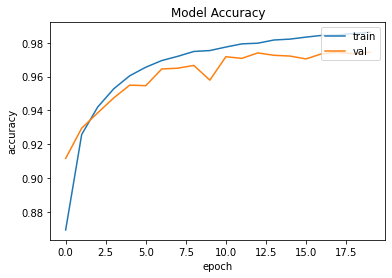

In [16]:
# Plot model accuracy over epoch if trained
if saved_model == 0:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    

In [25]:
%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 288), started 0:02:41 ago. (Use '!kill 288' to kill it.)

<IPython.core.display.Javascript object>